<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Tokenization
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Unigram tokenizer - Clinical Trials CTTI
  </div> 


  <div style=" float:left; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 
  
  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="TOC"></a>

#### Table Of Content

1. [Dataset](#data) <br>
2. [ALBERT finetuning](#albert) <br>
3. [Inference](#inference) <br>



#### Reference

- Hugginface full list of [tutorial notebooks](https://github.com/huggingface/transformers/tree/main/notebooks) (see also [here](https://huggingface.co/docs/transformers/main/notebooks#pytorch-examples))
- Huggingface full list of [training scripts](https://github.com/huggingface/transformers/tree/main/examples/pytorch)
- Huggingface [tutorial notebook](https://github.com/huggingface/notebooks/blob/main/examples/language_modeling_from_scratch.ipynb) on language models
- Huggingface [course](https://huggingface.co/course/chapter7/3?fw=tf) on language models
- Huggingface [training script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py) on language models
- SentencePiece Unigram logic described in [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (2018)](https://arxiv.org/pdf/1804.10959.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import random
import copy
import string
import json
from itertools import chain

# data
import pandas as pd
import numpy as np
from datasets import (
    Dataset, 
    DatasetDict,
    ClassLabel, 
    Features, 
    Sequence, 
    Value,
    load_from_disk,
)
import transformers
from transformers import AlbertConfig, AutoConfig, AutoTokenizer, AlbertTokenizerFast

# tokenize
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Transformers settings

In [3]:
transformers.__version__

'4.22.2'

#### Custom paths & imports

In [4]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets')
path_to_save = os.path.join(path_to_repo, 'saves', 'MLM')
path_to_src  = os.path.join(path_to_repo, 'src')

In [5]:
sys.path.insert(0, path_to_src)

#### Constants

In [6]:
dataset_name = 'clinical trials ICTRP/clinical-trials-ictrp'
base_model_name = "albert-base-v2"
final_model_name = "albert-small-ictrp"

<a id="data"></a>

# 1. Dataset

[Table of content](#TOC)

We generate a collection of instances of the `datasets.Dataset` class. 

Note that these are different from the fairly generic `torch.utils.data.Dataset` class. 

## 1.1 Load Clinical Trials corpus

[Table of content](#TOC)

In [7]:
with open(os.path.join(path_to_data, '{}.txt'.format(dataset_name)), 'r', encoding = 'utf-8') as f:
    texts = [t.strip() for t in f.readlines()]

In [8]:
dataset = Dataset.from_dict({'text': texts}, features = Features({'text': Value(dtype = 'string')}))

In [9]:
len(dataset)

1081670

In [10]:
dataset[:3]

{'text': ["Capable of giving signed informed consent. Has received, been intolerant to, or been ineligible for all treatment options proven, to confer clinical benefit. Measurable disease per Response Evaluation Criteria in Solid Tumors (RECIST) 1.1. Eastern Cooperative Oncology Group (ECOG) Performance status (PS) of 0 or 1. Adequate organ function. Male individuals and female individuals of childbearing potential who engage in, heterosexual intercourse must agree to use methods of contraception. Female participants are eligible if they are not pregnant, not breastfeeding or not a, Woman of childbearing potential (WOCBP). Inclusion criterion for the dose-escalation: Individuals with histologically or, cytologically confirmed, advanced or metastatic solid tumors. Inclusion criterion for disease-specific combination expansion: Individuals with, histologically or cytologically confirmed Triple-negative breast cancer (TNBC), Non-small cell lung cancer (NSCLC), Head and neck squamous cell 

## 1.2 Build tokenizer

[Table of content](#TOC)


In [11]:
def batch_iterator(dataset, batch_size = 512):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i: i + batch_size]['text']

In [12]:
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [13]:
v2i = base_tokenizer.get_vocab()
i2v = {i: v for v, i in v2i.items()}
[i2v[i] for i in range(5)]

['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]']

In [14]:
# issue with this ! yields badly formed vocabulary, with punctuations at middle of tokens
# tokenizer = base_tokenizer.train_new_from_iterator(batch_iterator(dataset, batch_size = 512), vocab_size = 5000)

In [15]:
# see the different pre-tokenizers at https://huggingface.co/docs/tokenizers/components#pretokenizers
# see also https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/tokenizer_training.ipynb#scrollTo=RZvnUm2PZV0H

custom_pre_tokenizer = pre_tokenizers.Sequence([
    # base albert pre-tokenizer
    pre_tokenizers.WhitespaceSplit(),
    pre_tokenizers.Metaspace(replacement = "▁", add_prefix_space = True),
    
    # isolate special characters in order not to have them at the middle of a word
    # this is put after Metaspace in order not to include extra spaces
    pre_tokenizers.Digits(),
    pre_tokenizers.Punctuation(behavior = "isolated"),
])

In [16]:
tokenizer = Tokenizer(models.Unigram())
tokenizer.normalizer     = base_tokenizer.backend_tokenizer.normalizer
tokenizer.pre_tokenizer  = custom_pre_tokenizer #base_tokenizer.backend_tokenizer.pre_tokenizer 
tokenizer.post_processor = base_tokenizer.backend_tokenizer.post_processor
tokenizer.decoder        = base_tokenizer.backend_tokenizer.decoder

In [17]:
# vocab_size has really unexpected behavior,
# see https://github.com/huggingface/tokenizers/issues/903
trainer = trainers.UnigramTrainer(
    vocab_size = 15000, 
    special_tokens = ['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]'], # order should be the same as base_tokenizer !
    unk_token = "<unk>",
)
tokenizer.train_from_iterator(batch_iterator(dataset, batch_size = 512), trainer = trainer)

In [18]:
tokenizer = AlbertTokenizerFast(tokenizer_object = tokenizer)

In [19]:
tokenizer.save_pretrained(os.path.join(path_to_save, final_model_name, 'tokenizer'))

('C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\saves\\MLM\\albert-small-ictrp\\tokenizer\\tokenizer_config.json',
 'C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\saves\\MLM\\albert-small-ictrp\\tokenizer\\special_tokens_map.json',
 'C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\saves\\MLM\\albert-small-ictrp\\tokenizer\\tokenizer.json')

In [20]:
v2i = tokenizer.get_vocab()
i2v = {i: v for v, i in v2i.items()}
[i2v[i] for i in range(5)]

['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]']

## 1.3 Inspect tokenizer

[Table of content](#TOC)


In [21]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save, final_model_name, 'tokenizer'))

In [22]:
len(tokenizer.get_vocab())

15000

<AxesSubplot: ylabel='Frequency'>

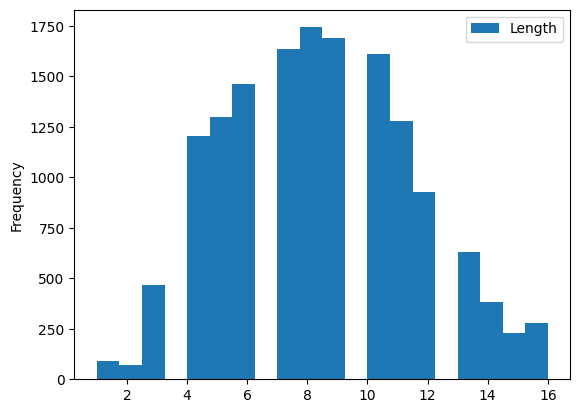

In [23]:
pd.DataFrame([len(t) for t in tokenizer.get_vocab()], columns = ['Length']).plot.hist(bins = 20)

In [24]:
[t for t in tokenizer.get_vocab() if len(t) <= 2]

['a',
 '29',
 'e',
 '64',
 'μl',
 '69',
 '16',
 'r',
 '”',
 '17',
 '00',
 '±',
 '88',
 '95',
 '~',
 'l',
 'y',
 '–',
 '‹',
 '§',
 'ð',
 '@',
 'd',
 'ck',
 '(',
 ']',
 '80',
 'in',
 'c',
 'be',
 'o',
 '¿',
 '?',
 'he',
 '×',
 'μg',
 'th',
 '°c',
 'm',
 '55',
 '%',
 'œ',
 '_',
 '27',
 'þ',
 '89',
 '28',
 'by',
 '1',
 '19',
 '25',
 '}',
 'ß',
 '+',
 'kg',
 '72',
 '50',
 'b',
 ':',
 '96',
 '38',
 'w',
 '=',
 ',',
 'μ',
 '39',
 ';',
 't',
 '2',
 'i',
 'j',
 'ul',
 'μm',
 '44',
 '6',
 'f',
 '#',
 '-',
 'us',
 'ly',
 'of',
 '▁',
 '24',
 '<',
 '°f',
 '—',
 'h',
 'x®',
 'mm',
 '·',
 'qu',
 'z',
 '35',
 'p',
 '8',
 '09',
 '>',
 '14',
 '48',
 '9',
 ')',
 '75',
 '’',
 '59',
 'x',
 'ju',
 'up',
 "'",
 '12',
 '£',
 '"',
 '&',
 '7',
 '`',
 '49',
 '13',
 '15',
 'g',
 'ø',
 'u',
 '18',
 '{',
 '.',
 '73',
 '40',
 '90',
 '20',
 '79',
 '85',
 'v',
 '60',
 '3',
 '30',
 'iv',
 '/',
 '45',
 '†',
 '70',
 'k',
 'or',
 '®',
 '36',
 '*',
 '26',
 '^',
 '‘',
 'q',
 '⁄',
 '[',
 '¬',
 '•',
 '99',
 '°',
 '4',
 '›',
 

In [25]:
tokenizer.get_vocab()

{'processing': 7930,
 'sulfonylurea': 12040,
 '▁periodic': 3169,
 'bal': 7395,
 'confirmation': 10441,
 '▁multifeta': 12481,
 '▁tcm': 5697,
 '▁unaffected': 9196,
 'rejuvenati': 13403,
 '▁cyp': 865,
 'performed': 6133,
 'ndan': 10142,
 'observance': 14734,
 '▁yellow': 4798,
 'intermediate': 9435,
 '▁expectoration': 12363,
 'desvenlafaxin': 14170,
 'ated': 1688,
 '▁spirits': 3841,
 '▁injection': 749,
 '▁patient': 77,
 'years': 1883,
 '▁registere': 2595,
 '▁propranolol': 7817,
 'benefit': 10535,
 'myelitis': 6618,
 '▁engagement': 9093,
 'terone': 12049,
 '▁ireland': 13843,
 'prilocaine': 14062,
 '▁observ': 11614,
 '▁hcp': 11632,
 'juan': 2956,
 '▁living': 1206,
 '▁confirmator': 3603,
 'a': 14,
 'aza': 4256,
 'lymph': 5627,
 'hpv': 8587,
 'paired': 10194,
 'trus': 7733,
 '▁with': 19,
 '▁natal': 3966,
 '▁matter': 5486,
 '▁hold': 6333,
 'gravid': 6203,
 '▁urethroplast': 14972,
 '▁respiratoire': 14574,
 '▁ophthalmic': 2832,
 '▁thromboplastin': 2360,
 '▁macrosomi': 11869,
 'lukast': 7494,
 '▁t

In [27]:
texts[0], tokenizer.decode(tokenizer(texts[0])['input_ids'])

("Capable of giving signed informed consent. Has received, been intolerant to, or been ineligible for all treatment options proven, to confer clinical benefit. Measurable disease per Response Evaluation Criteria in Solid Tumors (RECIST) 1.1. Eastern Cooperative Oncology Group (ECOG) Performance status (PS) of 0 or 1. Adequate organ function. Male individuals and female individuals of childbearing potential who engage in, heterosexual intercourse must agree to use methods of contraception. Female participants are eligible if they are not pregnant, not breastfeeding or not a, Woman of childbearing potential (WOCBP). Inclusion criterion for the dose-escalation: Individuals with histologically or, cytologically confirmed, advanced or metastatic solid tumors. Inclusion criterion for disease-specific combination expansion: Individuals with, histologically or cytologically confirmed Triple-negative breast cancer (TNBC), Non-small cell lung cancer (NSCLC), Head and neck squamous cell carcinoma

In [28]:
tokens = tokenizer.tokenize(texts[0])
ids = tokenizer(texts[0])['input_ids'][1:-1]
list(zip(tokens, ids))

[('▁capable', 857),
 ('▁of', 8),
 ('▁giving', 1377),
 ('▁signed', 343),
 ('▁informed', 90),
 ('▁consent', 78),
 ('.', 7),
 ('▁has', 72),
 ('▁received', 166),
 (',', 6),
 ('▁been', 172),
 ('▁intolerant', 2225),
 ('▁to', 13),
 (',', 6),
 ('▁or', 10),
 ('▁been', 172),
 ('▁ineligible', 1311),
 ('▁for', 20),
 ('▁all', 159),
 ('▁treatment', 56),
 ('▁options', 3610),
 ('▁proven', 1085),
 (',', 6),
 ('▁to', 13),
 ('▁confer', 8934),
 ('▁clinical', 103),
 ('▁benefit', 1432),
 ('.', 7),
 ('▁measurable', 483),
 ('▁disease', 42),
 ('▁per', 196),
 ('▁response', 515),
 ('▁evaluation', 473),
 ('▁criteria', 96),
 ('▁in', 21),
 ('▁solid', 881),
 ('▁tumors', 586),
 ('▁', 5),
 ('(', 12),
 ('recist', 2191),
 (')', 11),
 ('▁', 5),
 ('1', 18),
 ('.', 7),
 ('1', 18),
 ('.', 7),
 ('▁eastern', 826),
 ('▁cooperative', 734),
 ('▁oncology', 702),
 ('▁group', 337),
 ('▁', 5),
 ('(', 12),
 ('ecog', 682),
 (')', 11),
 ('▁performance', 335),
 ('▁status', 203),
 ('▁', 5),
 ('(', 12),
 ('p', 84),
 ('s', 15),
 (')', 11),

### TODO

- show examples of randomness in tokenization

[Table of content](#TOC)